<a href="https://colab.research.google.com/github/jsebastianquiroga/Analitica_2/blob/main/Deep_Learning/NYU_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning

fatal: destination path 'pytorch-Deep-Learning' already exists and is not an empty directory.


In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [3]:
import os
os.chdir('pytorch-Deep-Learning')

In [4]:
from res.plot_lib import plot_data, plot_model, set_default

In [5]:
set_default()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
seed = 12345
torch.manual_seed(seed)
N = 1000  # observaciones_por_clase
n = 2     #dimensiones/variables
K = 5      #lables/clases
d = 100   # Cantidad_capas_ocultas

In [11]:
# Crear un tensor de zeros con la forma (N * C, D) y moverlo al dispositivo (GPU o CPU)
X = torch.zeros(N * C, D).to(device)

# Crear un tensor de zeros con la forma (N * C) y especificar el tipo de dato como 'long'
# Luego moverlo al dispositivo (GPU o CPU)
y = torch.zeros(N * C, dtype=torch.long).to(device)

# Iterar a través de todos los elementos en el rango de C
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    
    # Calcular el 'inner_var' usando linspace y agregar ruido
    inner_var = torch.linspace(
        # Inicio del linspace cuando t = 0
        (2 * math.pi / C) * c,
        # Fin del linspace cuando t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2

    # Iterar a través del rango de N * c a N * (c + 1)
    for ix in range(N * c, N * (c + 1)):
        # Asignar el valor de t[index] multiplicado por un tensor creado a partir de sin(inner_var[index]) y cos(inner_var[index])
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        
        # Asignar el valor de 'c' al tensor 'y' en la posición 'ix'
        y[ix] = c
        index += 1

# Imprimir las dimensiones de los tensores 'X' e 'y'
print("shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

shapes:
X: (3000, 2)
y: (3000,)


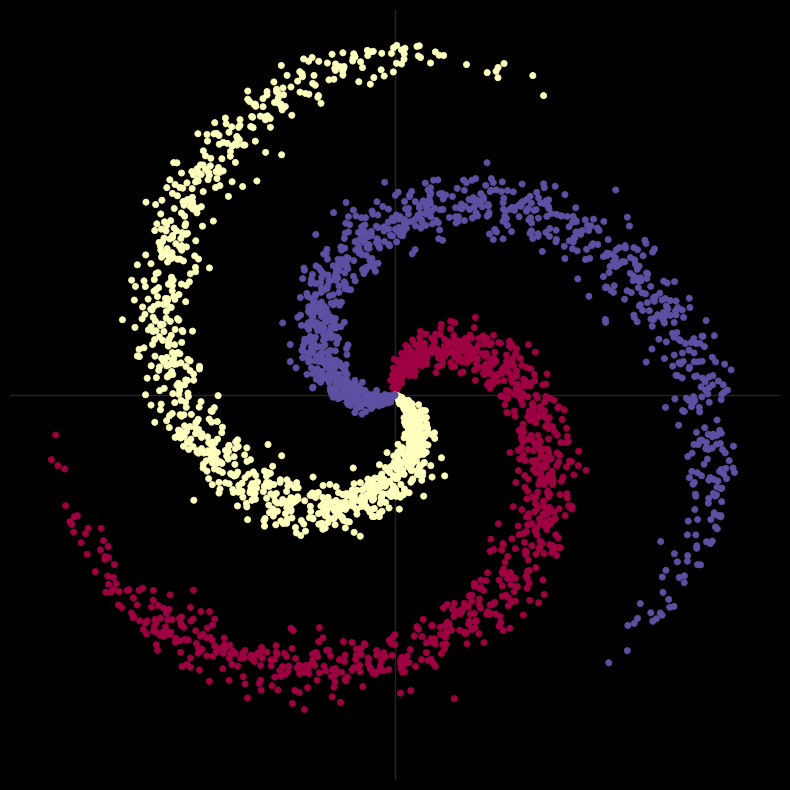

In [13]:
plot_data(X, y)

# Modelo Lineal

In [17]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [21]:
import sys

def overwrite(text):
    sys.stdout.write("\r" + text)
    sys.stdout.flush()
def acc(logits, labels):
    _, predictions = torch.max(logits, dim=1)
    correct = (predictions == labels).sum().item()
    total = labels.numel()
    return correct / total

In [22]:
# Definición del modelo
model = nn.Sequential(
    nn.Linear(n, d),
    # nn.ReLU(),  # Comenta esta línea para un modelo lineal
    nn.Linear(d, K)  # (Opcional) Comenta esta línea y descomenta la siguiente para mostrar incrustaciones 2D a continuación
    # nn.Linear(d, 2), nn.Linear(2, K)
)
model.to(device)  # enviar al dispositivo (GPU o CPU) si es posible

# Calcular la entropía cruzada dado los logits de salida
C = torch.nn.CrossEntropyLoss(reduction='none')

# Utilizar el optimizador Adam
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)  # L2 incorporado

# Bucle de entrenamiento en lotes completos
for t in range(2_000):
    
    # Realizar una pasada hacia adelante para obtener los logits
    l = model(X)
    
    # Calcular la energía libre F
    F = C(l, y)
    L = F.mean()
    
    # Poner a cero los gradientes
    optimiser.zero_grad()
    
    # Pasada hacia atrás para calcular y acumular el gradiente
    # de la energía libre con respecto a nuestros parámetros aprendibles
    L.backward()
    
    # Actualizar los parámetros
    optimiser.step()
    
    # Mostrar la época, L y la precisión
    overwrite(f'[EPOCH]: {t}, [LOSS]: {L.item():.6f}, [ACCURACY]: {acc(l, y):.3f}')

[EPOCH]: 1999, [LOSS]: 0.775321, [ACCURACY]: 0.507

In [ ]:
print(model)
plot_model(X, y, model)

In [ ]:

# (Optional) Plot internal 2D embeddings if available
plot_embeddings(X, y, model, zoom=10)

In [ ]:
# Crear una malla de valores en el rango de -1.5 a 1.5 con incrementos de 0.01
mesh = torch.arange(-1.5, 1.5, 0.01)

# Crear una malla de coordenadas a partir de los valores de 'mesh'
xx, yy = torch.meshgrid(mesh, mesh)

# Combinar las coordenadas 'xx' e 'yy' en un solo tensor 'grid'
grid = torch.stack((xx.reshape(-1), yy.reshape(-1)), dim=1)

# Calcular los logits para todos los puntos en la malla sin calcular gradientes
with torch.no_grad():
    logits = model(grid)

In [ ]:
# Elección de la energía libre

fe = 'cross-entropy'
# fe = 'negative logit'

In [ ]:
# Cambiar a modo no interactivo en matplotlib
%matplotlib inline

# Establecer los valores predeterminados de visualización para matplotlib
set_default()

In [ ]:
# ! mkdir {m}-levels

In [ ]:
# Graficar niveles de energía en 2D

for k in range(K):
    if fe == 'cross-entropy':
        # Calcular la energía libre F como entropía cruzada
        F = C(logits, torch.LongTensor(1).fill_(k).expand(logits.size(0)))
        F = F.reshape(xx.shape)
        # Graficar los niveles de energía en 2D usando la función plot_2d_energy_levels
        plot_2d_energy_levels(X, y, (xx, yy, F, k, K), (0, 35), (1, 35, 4))

    elif fe == 'negative logit':
        # Calcular la energía libre F como logit negativo
        F = -logits[:, k]
        F = F.reshape(xx.shape)
        # Graficar los niveles de energía en 2D usando la función plot_2d_energy_levels
        plot_2d_energy_levels(X, y, (xx, yy, F, k, K), (-20, 20), (-20, 21, 2.5))
        
    # Descomenta la siguiente línea para guardar las gráficas como imágenes en formato PNG
    # plt.savefig(f'{m}-levels/{k}.png', bbox_inches='tight')


In [ ]:
# Cambiar a modo interactivo en matplotlib
%matplotlib notebook

# Establecer los valores predeterminados de visualización para matplotlib
set_default()


In [ ]:
# Entropía cruzada
if fe == 'cross-entropy':
    # Graficar los niveles de energía en 3D usando la función plot_3d_energy_levels
    fig, ax = plot_3d_energy_levels(X, y, (xx, yy, F, k, K), (0, 18), (0, 19, 1), (0, 19, 2))

# Logit negativo
elif fe == 'negative logit':
    # Graficar los niveles de energía en 3D usando la función plot_3d_energy_levels
    fig, ax = plot_3d_energy_levels(X, y, (xx, yy, F, k, K), (-30, 20), (-30, 20, 1), (-30, 21, 5))

In [ ]:
# Girar la gráfica en 3D (y quizás guardar en disco)
δ = 10
for angle in range(0, 360, δ):
    # Establecer el ángulo de visión de la gráfica en 3D
    ax.view_init(30, -60 + angle)
    # Actualizar la gráfica en el canvas
    fig.canvas.draw()
    # Descomenta la siguiente línea para pausar brevemente antes de cambiar el ángulo
    # plt.pause(.001)
    # Descomenta la siguiente línea para guardar la gráfica en 3D con el ángulo actual en formato PNG
    # plt.savefig(f'{m}-3d-levels/{angle:03d}.png', bbox_inches='tight')